In [2]:
!python -m pip install -U gensim
!python -m pip install -U nltk
!pip install pyLDAvis==3.2.2

#nltk.download('punkt')

import gensim
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
#from gensim import corpora, models
import pyLDAvis.gensim
import os

df = pd.read_csv('cleaned_data.csv')
df.columns

Requirement already up-to-date: gensim in /opt/conda/lib/python3.7/site-packages (4.1.2)
Requirement already up-to-date: nltk in /opt/conda/lib/python3.7/site-packages (3.6.5)


Index(['Unnamed: 0', 'review_id', 'business_id', 'stars', 'text',
       'clean_text'],
      dtype='object')

In [3]:
#clean_text is already tokensized text 
#docs=df['text'].apply(word_tokenize)

docs = df['clean_text'].apply(word_tokenize)
print(docs[0][0:20])

['great', 'food', 'recommend', 'grill', 'shrimp', 'app', 'white', 'bean', 'soup', 'brussel', 'sprout', 'risotto', 'lamb', 'great', 'wine', 'select', 'interest', 'cocktail', 'menu', 'good']


In [4]:
# Unigrams

uni_dict = gensim.corpora.Dictionary(docs)

#convert docs to vec
uni_corpus = [uni_dict.doc2bow(docs) for docs in docs]
print(uni_corpus[0][0:20])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]


In [5]:
# Creating Bigrams
bigram_phrases = gensim.models.Phrases(docs, min_count=5, threshold=25)
bigram = gensim.models.phrases.Phraser(bigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

bigrams_data = make_bigrams(docs)

print(bigrams_data[35])

['came', 'visit', 'sat', 'bar', 'never', 'even', 'heard', 'place', 'came', 'friend', 'recommend', 'quit', 'treat', 'arriv', 'tyson', 'beckford', 'andi', 'buckley', 'offic', 'also', 'sit', 'bar', 'quit', 'star', 'stud', 'even', 'asid', 'bartend', 'joe', 'fantast', 'realli', 'know', 'make', 'good', 'drink', 'order', 'burger', 'also', 'realli', 'good', 'saw', 'small', 'patio', 'equip', 'fire_pit', 'seem', 'like', 'would', 'perfect', 'stop', 'romant', 'even']


In [43]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = gensim.corpora.Dictionary(bigrams_data)

texts = bigrams_data

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)
print(tfidf)


low_value = 0.2
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

TfidfModel(num_docs=351, num_nnz=18992)


In [41]:
#LDA model

#chunksize is the number of documents to be used in each training chunk.\
#update_every determines how often the model parameters should be updated
#passes is the total number of training passes.

ldagensim1 = gensim.models.ldamodel.LdaModel(corpus = uni_corpus, 
                                           num_topics = 8, 
                                           id2word = uni_dict, 
                                           random_state = 123, 
                                           update_every = 1, 
                                           chunksize = 100, 
                                           passes = 10, 
                                           alpha = 'auto')

vecTop= ldagensim1.show_topics()
vecTop
# for i in range(0, 5):
#     print(vecTop[i])

[(0,
  '0.020*"lobster" + 0.013*"smore" + 0.012*"fri" + 0.010*"aragosta" + 0.010*"event" + 0.009*"got" + 0.008*"fire" + 0.008*"clambak" + 0.008*"calamari" + 0.007*"voucher"'),
 (1,
  '0.034*"ravioli" + 0.024*"goat" + 0.022*"appl" + 0.016*"martini" + 0.013*"lobster" + 0.009*"occas" + 0.009*"minestron" + 0.008*"picki" + 0.007*"patrick" + 0.007*"limit"'),
 (2,
  '0.011*"de" + 0.009*"sidewalk" + 0.008*"crave" + 0.008*"touch" + 0.007*"harbor" + 0.007*"1800" + 0.007*"saffron" + 0.007*"utensil" + 0.006*"garden" + 0.006*"famili"'),
 (3,
  '0.012*"gorgeou" + 0.010*"peachtre" + 0.010*"favorit" + 0.010*"battl" + 0.009*"within" + 0.009*"spot" + 0.008*"joint" + 0.008*"marinara" + 0.008*"tomato" + 0.008*"vino"'),
 (4,
  '0.018*"food" + 0.011*"servic" + 0.011*"us" + 0.011*"good" + 0.010*"tabl" + 0.010*"restaur" + 0.009*"wait" + 0.009*"order" + 0.008*"would" + 0.007*"back"'),
 (5,
  '0.044*"park" + 0.035*"al" + 0.029*"bacio" + 0.023*"ave" + 0.019*"italian" + 0.017*"coffe" + 0.014*"breakfast" + 0.013*"

In [44]:
#LDA model

#chunksize is the number of documents to be used in each training chunk.\
#update_every determines how often the model parameters should be updated
#passes is the total number of training passes.

ldagensim = gensim.models.ldamodel.LdaModel(corpus = corpus, 
                                           num_topics = 8, 
                                           id2word = id2word, 
                                           random_state = 123, 
                                           update_every = 1, 
                                           chunksize = 100, 
                                           passes = 10, 
                                           alpha = 'auto')

vecTop= ldagensim.show_topics()
vecTop
# for i in range(0, 5):
#     print(vecTop[i])

[(0,
  '0.035*"us" + 0.022*"plate" + 0.014*"smore" + 0.013*"martini" + 0.013*"lasagna" + 0.012*"favorit" + 0.010*"el" + 0.010*"despit" + 0.010*"cute" + 0.009*"simpl"'),
 (1,
  '0.018*"gnocchi" + 0.016*"tea" + 0.015*"pastri" + 0.012*"point" + 0.012*"tuna" + 0.010*"minut" + 0.009*"total" + 0.009*"wait" + 0.008*"coupon" + 0.008*"smaller"'),
 (2,
  '0.019*"clear" + 0.013*"pasta" + 0.012*"arugula" + 0.010*"pretti" + 0.010*"employe" + 0.010*"groupon" + 0.009*"wine" + 0.009*"meatbal" + 0.008*"must" + 0.008*"relax"'),
 (3,
  '0.014*"chicken" + 0.014*"mom" + 0.011*"touch" + 0.011*"margherita" + 0.010*"lunch" + 0.010*"view" + 0.010*"al_bacio" + 0.008*"reserv" + 0.008*"owner" + 0.008*"strong"'),
 (4,
  '0.030*"excel" + 0.030*"pizza" + 0.016*"final" + 0.014*"burger" + 0.013*"gf" + 0.013*"call" + 0.012*"coffe" + 0.011*"clambak" + 0.011*"occas" + 0.011*"bit"'),
 (5,
  '0.013*"famili" + 0.013*"experi" + 0.012*"worst" + 0.011*"old" + 0.011*"amaz" + 0.010*"slice" + 0.010*"parm" + 0.009*"pepperoni" + 0.

In [45]:
from gensim.models.coherencemodel import CoherenceModel
# cm = CoherenceModel(model=ldagensim, texts = docs, coherence='c_v')
# coherence = cm.get_coherence() 

# Compute Perplexity
print('\nPerplexity: ', ldagensim.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
#print('\nPerplexity: ', ldagensim1.log_perplexity(uni_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
cm = CoherenceModel(model= ldagensim, texts= bigrams_data, dictionary=id2word, coherence='c_v')
#unigram
#cm = CoherenceModel(model= ldagensim1, texts= docs, dictionary=uni_dict, coherence='c_v')
coherence = cm.get_coherence()
print('\nCoherence Score: ', coherence)


Perplexity:  -8.061444935972455

Coherence Score:  0.5446240230038483


In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, 
                                           num_topics = num_topics, 
                                           id2word = id2word, 
                                           random_state = 123, 
                                           update_every = 1, 
                                           chunksize = 100, 
                                           passes = 10, 
                                           alpha = 'auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence ='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary = id2word, corpus = corpus, texts = bigrams_data, start=2, limit=20, step=3)

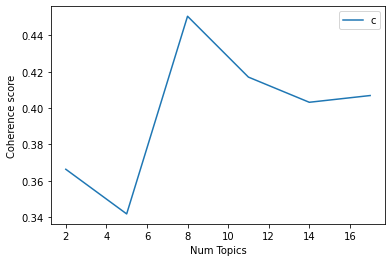

In [28]:
# Show graph
import matplotlib.pyplot as plt
%matplotlib inline

limit=20; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Visualizing the data 

In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldagensim, corpus,id2word,mds = "mmds",R = 20)
vis 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.177106  0.257826       1        1  66.131817
3      0.106184  0.255726       2        1   9.447913
0      0.266468 -0.095714       3        1   8.434241
1     -0.268946 -0.043907       4        1   6.348358
2      0.142753  0.016754       5        1   3.695730
4     -0.035686 -0.028744       6        1   3.310402
5     -0.071945 -0.221530       7        1   2.228895
6      0.038278 -0.140411       8        1   0.402644, topic_info=           Term        Freq       Total Category  logprob  loglift
250          us  131.000000  131.000000  Default  20.0000  20.0000
474       pizza   71.000000   71.000000  Default  19.0000  19.0000
244        tabl  136.000000  136.000000  Default  18.0000  18.0000
146        wait  107.000000  107.000000  Default  17.0000  17.0000
19         nice  110.000000  110.000000  Default  16.0000  16.0000
...         ...         ...         ...      ...      ...      ...
3279        del    0.445398    1.107614   Topic8  -5.3212   4.6039
3280    domingo    0.445398    1.107614   Topic8  -5.3212   4.6039
3281         dã    0.445398    1.107614   Topic8  -5.3212   4.6039
3283  enamorado    0.445398    1.107614   Topic8  -5.3212   4.6039
3284   excelent    0.445398    1.107614   Topic8  -5.3212   4.6039

[291 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
211       4  0.918179  10_minut
1186      6  0.908543        11
681       4  0.763485  20_minut
681       7  0.190871  20_minut
721       4  0.865484        25
...     ...       ...       ...
477       4  0.171937      year
477       6  0.057312      year
477       7  0.229250      year
1976      3  0.165415     young
1976      6  0.661659     young

[405 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 1, 2, 3, 5, 6, 7])

In [30]:
all_topics = ldagensim.get_document_topics(corpus,minimum_probability = 0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)

all_topics_df

,0,1,2,3,4,5,6,7
0,0.044351,0.249944,0.002004,0.005815,0.002796,0.002627,0.000619,0.691844
1,0.002048,0.016674,0.093201,0.415378,0.000854,0.016255,0.000189,0.455400
2,0.093317,0.304499,0.002202,0.006269,0.003078,0.002887,0.000681,0.587067
3,0.007212,0.004957,0.002150,0.006003,0.003000,0.002818,0.000665,0.973195
4,0.003792,0.739999,0.001149,0.003177,0.001605,0.001506,0.000355,0.248416
...,...,...,...,...,...,...,...,...
346,0.004651,0.075698,0.018236,0.329640,0.035594,0.001810,0.000427,0.533944
347,0.007842,0.005495,0.002378,0.006832,0.003319,0.395735,0.000735,0.577664
348,0.047308,0.194345,0.000522,0.001436,0.006790,0.006670,0.000161,0.742768
349,0.348098,0.047894,0.017443,0.125053,0.023711,0.000487,0.000115,0.437198


# Optimal number of topics for LDA

In [31]:
## To fix jupyter notebook format

from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

# Finding the dominant topic for each doc and labelling docs

In [31]:
import joblib
#Save a model to disk, or reload a pre-trained model

joblib.dump(ldagensim, 'reviews_ldagensim.jl')

# then reload it with
ldagensim_disk = joblib.load('reviews_ldagensim.jl')

In [32]:
vecTop= ldagensim_disk.show_topics()
for i in range(0, 2):
    print(vecTop[i])

(0, '0.013*"italian" + 0.012*"slow" + 0.010*"famili" + 0.010*"mani" + 0.009*"menu" + 0.009*"restaur" + 0.009*"alway" + 0.008*"favorit" + 0.008*"dine_experi" + 0.008*"come_back"')
(1, '0.019*"us" + 0.014*"waitress" + 0.012*"minut" + 0.011*"hostess" + 0.010*"tabl" + 0.009*"gf" + 0.009*"clear" + 0.008*"reserv" + 0.008*"wait" + 0.008*"size"')


In [34]:
#map the reviews data to the model, v is the reviews transformed to word vectors by doc2bow
m = ldagensim[corpus[0:len(corpus)]]

#assign topic to each review
import operator 
topic = []
for x in m:
    #find the topic with the highest proportions
    t = max(x, key = operator.itemgetter(1))
    topic.append(t[0])
    
df['topic'] = topic
topic[0]
m[0]

[(0, 0.044353813),
 (1, 0.24994287),
 (2, 0.0020037536),
 (3, 0.005820509),
 (4, 0.0027959524),
 (5, 0.0026269408),
 (6, 0.0006193552),
 (7, 0.69183683)]

In [36]:
df.iloc[5]

Unnamed: 0                                                     5
review_id                                 aglpU--vi76j2r3BEdmolA
business_id                               kVI7NL59MPnYTx3Lg6PMTw
stars                                                          1
text           i went there last night...we were outside on t...
clean_text     went last nightw outsid patio good view ambian...
topic                                                          7
Name: 5, dtype: object

In [38]:
#map topic names to the topic numbers
# topic_dict = {0:'Atmosphere', 1:'Food', 2:'Service',
#              3:'Food', 4:'Waiting time', 5:'Food',
#              6:'Food', 7:'Hospitality'}
topic_dict = {0:'Service', 1:'Food',2:'Ambience',
             3:'Wait time',4:'Food',5:'Food',6:'Food',7:'Food'}

df = df.replace({'topic':topic_dict})

In [39]:
df.head(10)

,Unnamed: 0,review_id,business_id,stars,text,clean_text,topic
0,0,z_VY1RNU2nWO6kaAVt28nw,kVI7NL59MPnYTx3Lg6PMTw,4,"great food. recommend the grilled shrimp app, ...",great food recommend grill shrimp app white be...,Food
1,1,iz89hnkkU5MXSvODiIKiaA,kVI7NL59MPnYTx3Lg6PMTw,4,there is definitely a wow factor when you ente...,definit wow factor enter restaur hotel dim lig...,Food
2,2,T8vxPxV_0Nvh7T9G7zfE8A,eLrJdEYwxzJgddnqawDQ1g,5,my boyfriend took me here the last time i was ...,boyfriend took last time visit john creek area...,Food
3,3,LSvhBCb8q0tytFd1x4eB3A,kVI7NL59MPnYTx3Lg6PMTw,4,food was great. \r\nservice was great. \r\nbar...,food great servic great bartend spill dark dri...,Food
4,4,Kv9VEmLpM285jD8SVVqUPw,kVI7NL59MPnYTx3Lg6PMTw,1,we went for afternoon tea and pasties on sunda...,went afternoon tea pasti sunday call earlier w...,Food
5,5,aglpU--vi76j2r3BEdmolA,kVI7NL59MPnYTx3Lg6PMTw,1,i went there last night...we were outside on t...,went last nightw outsid patio good view ambian...,Food
6,6,uo-O3xXjKWGXB93k7RwBgg,kVI7NL59MPnYTx3Lg6PMTw,4,i always get a little wary when i see a 2-2.5 ...,alway get littl wari see 225 star rate busi on...,Food
7,7,dncq4ag15doR-G7uDKhaJw,_pqPht0BqDsU3Fcla_s7iw,5,another one on my fav list and what a better w...,anoth one fav list better way start earli sund...,Food
8,8,Be-2UIdklRMNMieXoTN8gQ,eLrJdEYwxzJgddnqawDQ1g,4,pasta vino started out as broadway danny's yea...,pasta vino start broadway danni year year ago ...,Food
9,9,yc9uxICf7hb0LPfjQteAIg,eLrJdEYwxzJgddnqawDQ1g,2,portion size is good and staff is friendly wit...,portion size good staff friendli cool atmosphe...,Food


In [40]:
df.to_csv("Sample_labelled_data.csv")